In [1]:
`import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

In [2]:
data_train = torchvision.datasets.MNIST('./data/', 
                                        train=True, download=True,
                                        transform=torchvision.transforms.Compose
                                        ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                        ]))
data_test = torchvision.datasets.MNIST('./data/', 
                                       train=False, download=True,
                                       transform=torchvision.transforms.Compose
                                       ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                       ]))

In [3]:
import torch

batch_size_train = 64
batch_size_test = 512

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size=batch_size_train, 
                                                shuffle=True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size=batch_size_test, 
                                               shuffle=True)

In [4]:
examples = enumerate(data_loader_train)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data[0][0])
example_data[0][0].shape
example_data[0].shape

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

torch.Size([1, 28, 28])

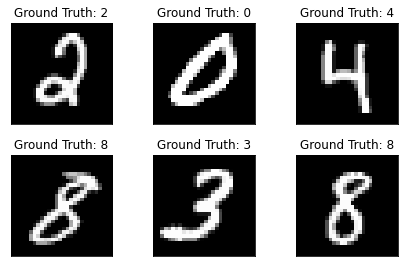

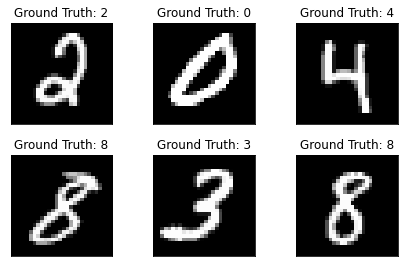

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
import brevitas.nn as qnn
import torch
import torch.nn as nn
from torch.nn import Module
from brevitas.inject.enum import QuantType

# Setting seeds for reproducibility
torch.manual_seed(1)

class BiKAThreshold(Module):
    def __init__(self):
        super(BiKAThreshold, self).__init__()

        self.bn = nn.BatchNorm1d(1)
        self.sign = qnn.QuantIdentity(
                         quant_type=QuantType.BINARY,
                         scaling_impl_type='const',
                         bit_width=1,
                         min_val=-1.0,
                         max_val=1.0, 
                         return_quant_tensor=False
                         )

    def forward(self, x):
        out = self.sign(self.bn(x))
        return out

class BiKANeuron(Module):
    def __init__(self, in_channels):
        super(BiKANeuron, self).__init__()
        self.thresholds = nn.ModuleList([BiKAThreshold() for _ in range(in_channels)])

    def forward(self, x):
        # Apply BatchNorm and Quantization to each input channel
        out = torch.cat([threshold(x[:, i:i+1]) for i, threshold in enumerate(self.thresholds)], dim=1)
        return out.sum(dim=1)

class BiKALinear(Module):
    def __init__(self, in_channels, out_channels):
        super(BiKALinear, self).__init__()
        self.neurons = nn.ModuleList([BiKANeuron(in_channels) for _ in range(out_channels)])

    def forward(self, x):
        # Apply the BiKANeuron to each output channel
        out = torch.stack([neuron(x) for neuron in self.neurons], dim=1)
        return out

class BiKA(Module):
    def __init__(self):
        super(BiKA, self).__init__()
        self.fc0 = BiKALinear(784, 10)
        self.fc1 = BiKALinear(10, 10)

    def forward(self, x):
        out = x.view(x.shape[0], -1)  # Flatten input
        out = self.fc0(out)
        out = self.fc1(out)
        return out

model = BiKA()

In [7]:
thres = BiKAThreshold()
thres_in = torch.tensor([[0.0],[1.0],[2.0],[3.0]])
print(thres_in)
print(thres_in.shape)
thres_out = thres(thres_in)
print(thres_out)
print(thres_out.shape)

tensor([[0.],
        [1.],
        [2.],
        [3.]])
torch.Size([4, 1])
tensor([[-1.],
        [-1.],
        [ 1.],
        [ 1.]], grad_fn=<MulBackward0>)
torch.Size([4, 1])


In [8]:
neuron = BiKANeuron(2)
neuron_in = torch.tensor([[0.0, 4.0],[1.0, 5.0],[2.0, 6.0],[3.0, 7.0]])
print(neuron_in)
print(neuron_in.shape)
neuron_out = neuron(neuron_in)
print(neuron_out)
print(neuron_out.shape)

tensor([[0., 4.],
        [1., 5.],
        [2., 6.],
        [3., 7.]])
torch.Size([4, 2])
tensor([-2., -2.,  2.,  2.], grad_fn=<SumBackward1>)
torch.Size([4])


In [9]:
linear = BiKALinear(2,2)
linear_in = torch.tensor([[0.0, 4.0],[1.0, 5.0],[2.0, 6.0],[3.0, 7.0]])
print(linear_in)
print(linear_in.shape)
linear_out = linear(linear_in)
print(linear_out)
print(linear_out.shape)

tensor([[0., 4.],
        [1., 5.],
        [2., 6.],
        [3., 7.]])
torch.Size([4, 2])
tensor([[-2., -2.],
        [-2., -2.],
        [ 2.,  2.],
        [ 2.,  2.]], grad_fn=<StackBackward0>)
torch.Size([4, 2])


In [10]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        #inputs, target = inputs.cuda(), target.cuda()
        inputs, target = Variable(inputs), Variable(target)
        
        outputs = model(inputs)
        _,pred = torch.max(outputs.data,1)
        
        optimizer.zero_grad()
        loss = criterion(outputs,target)
 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.numpy()) 
           
    return losses

In [11]:
import torch
from sklearn.metrics import accuracy_score

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            #inputs, target = inputs.cuda(), target.cuda()
            inputs, target = Variable(inputs),Variable(target)
            output = model(inputs)
            #output = torch.sigmoid(output_orig)  
            _,pred = torch.max(output,1)
            # compare against a threshold of 0.5 to generate 0/1
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [12]:
num_epochs = 20
learn_rate = 0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [13]:
# loss criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, betas=(0.9, 0.999))

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        test_acc = test(model, data_loader_test)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)

Training loss = 7.581144 test accuracy = 0.174800: 100%|█| 20/20 [7:56:46<00:


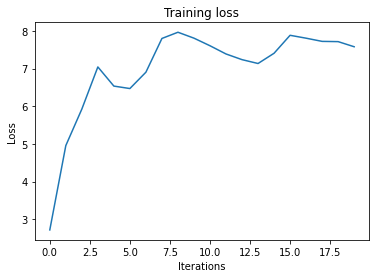

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

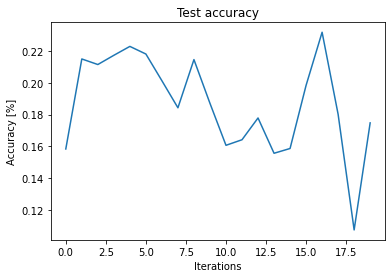

In [16]:
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [17]:
test(model, data_loader_test)

0.1748